<a href="http://tinypic.com?ref=2r5erf5" target="_blank"><img src="http://i67.tinypic.com/2r5erf5.jpg" border="0" alt="Image and video hosting by TinyPic"></a>

# <center> <span style="color:orange"> Analysis of Customer Reviews on G2Crowd for Backup Solutions </span> </center>

### Problem Statement:

The objective of this analysis is to discover useful text patterns from reviews of backup solutions by customers. It is intended to reveal words/phrases used by customers to describe what they want/do no want from a backup solution. This will enable the Customer Marketing team develop tailored communications that speak the language of customers and focussed on key terms that capture customers' attention

### Methodology:

* The approach is to scrape online review comments of backup customers for the analysis. 
* G2 Crowd review data was used for the analysis
* Solarwinds backup solution is the clear leader on G2 Crowd and closely followed by Datto Backupify. Customers' reviews for these 2 solutions were scraped and analysed  
 <br/>
* There are five fields per review on G2 Crowd namely: 
    - Review Title
    - What do you like best?
    - What do you dislike?
    - Recommendations to others considering the product
    - What business problems are you solving with the product?  What benefits have you realized?
 <br/>
 <br/> 
* This analysis is only focussed on two of these fields for comparative purpose:
    - What do you like best?
    - What do you dislike?

## <span style="color:orange"> The Analysis </span>

### Scrape Data from G2 Crowd

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re, string, unicodedata
import contractions
import inflect
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
from nltk import FreqDist
import spacy
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
%matplotlib inline
from gensim.summarization import summarize
from gensim.summarization import keywords

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """


In [3]:
# Create dataframe to hold review details for backupify 

Final_dict = {"Review_Title" : [], \
              "What do you like best?" : [], \
              "What do you dislike?" : [], \
              "Recommendations to others considering the product" : [],\
              "What business problems are you solving with the product?  What benefits have you realized?" : []}

backupify_links = ['https://www.g2.com/products/datto-backupify/reviews',\
                   'https://www.g2.com/products/datto-backupify/reviews?page=2']

for i in backupify_links:
    
    g2_response = requests.get(i).text
    soup = BeautifulSoup(g2_response, 'lxml')
    
    for broad_body in soup.find_all('div', class_ = 'mb-2 border-bottom'):
        Title = broad_body.h3.text
        Final_dict["Review_Title"].append(Title)
        summary = broad_body.find('div', itemprop = 'reviewBody')
        keys_ = []
        values_ = []
        initial_dict = {}
        for i in summary.find_all('h5'):
            keys_.append(i.text)
        for p in summary.find_all('div'):
            values_.append(p.text)
        initial_dict = initial_dict.fromkeys(keys_)
        for i,j in zip(initial_dict.keys(), range(0,len(initial_dict))):
            initial_dict[i] = values_[j]
        if "What do you like best?" in initial_dict:
            b = initial_dict.get("What do you like best?")
        else:
            b = None
        Final_dict["What do you like best?"].append(b)
        if "What do you dislike?" in initial_dict:
            b = initial_dict.get("What do you dislike?")
        else:
            b = None
        Final_dict["What do you dislike?"].append(b)
        if "Recommendations to others considering the product" in initial_dict:
            b = initial_dict.get("Recommendations to others considering the product")
        else:
            b = None
        Final_dict["Recommendations to others considering the product"].append(b)
        if "What business problems are you solving with the product?  What benefits have you realized?" in initial_dict:
            b = initial_dict.get("What business problems are you solving with the product?  What benefits have you realized?")
        else:
            b = None
        Final_dict["What business problems are you solving with the product?  What benefits have you realized?"].append(b)

df_backupify = pd.DataFrame(Final_dict)   

df_backupify.head()

,Review_Title,What do you like best?,What do you dislike?,Recommendations to others considering the product,What business problems are you solving with the product? What benefits have you realized?
0,"""Exactly what we needed.""",Ease of use and visibility. It was very easy t...,There seems to a lag in loading the web interf...,None,None
1,"""Easy and pain-free backup for your domain.""",I enjoyed the ease of setup the most. Configur...,If I had to choose one thing that I disliked i...,None,None
2,"""A MUST HAVE for any IT organization""",I love that Backupify reliably backs up email ...,The user interface can be a bit clunky at time...,None,None
3,"""Simple and affordable Backup of our corporate...",We use Backupify to store and keep all of our ...,The Dashboard only allows you to see 10 users ...,None,None
4,"""One of the easiest value added services to se...",Anytime I can sell a product or service that b...,There isn't much to dislike about this product...,None,None


In [21]:
print('We were able to extract {} reviews for Datto Backupify solution'.format(df_backupify.shape[0]))

We were able to extract 59 reviews for Datto Backupify solution


In [11]:
# Create dataframe to hold review details for solarwinds backup 

Final_dict = {"Review_Title" : [], \
              "What do you like best?" : [], \
              "What do you dislike?" : [], \
              "Recommendations to others considering the product" : [],\
              "What business problems are you solving with the product?  What benefits have you realized?" : []}

solarwinds_links = ['https://www.g2.com/products/solarwinds-backup/reviews',\
                   'https://www.g2.com/products/solarwinds-backup/reviews?page=2',\
                  'https://www.g2.com/products/solarwinds-backup/reviews?page=3']

for i in solarwinds_links:
    
    g2_response = requests.get(i).text
    soup = BeautifulSoup(g2_response, 'lxml')
    
    for broad_body in soup.find_all('div', class_ = 'mb-2 border-bottom'):
        Title = broad_body.h3.text
        Final_dict["Review_Title"].append(Title)
        summary = broad_body.find('div', itemprop = 'reviewBody')
        keys_ = []
        values_ = []
        initial_dict = {}
        for i in summary.find_all('h5'):
            keys_.append(i.text)
        for p in summary.find_all('div'):
            values_.append(p.text)
        initial_dict = initial_dict.fromkeys(keys_)
        for i,j in zip(initial_dict.keys(), range(0,len(initial_dict))):
            initial_dict[i] = values_[j]
        if "What do you like best?" in initial_dict:
            b = initial_dict.get("What do you like best?")
        else:
            b = None
        Final_dict["What do you like best?"].append(b)
        if "What do you dislike?" in initial_dict:
            b = initial_dict.get("What do you dislike?")
        else:
            b = None
        Final_dict["What do you dislike?"].append(b)
        if "Recommendations to others considering the product" in initial_dict:
            b = initial_dict.get("Recommendations to others considering the product")
        else:
            b = None
        Final_dict["Recommendations to others considering the product"].append(b)
        if "What business problems are you solving with the product?  What benefits have you realized?" in initial_dict:
            b = initial_dict.get("What business problems are you solving with the product?  What benefits have you realized?")
        else:
            b = None
        Final_dict["What business problems are you solving with the product?  What benefits have you realized?"].append(b)

df_sw_backup = pd.DataFrame(Final_dict)   

df_sw_backup.head()

,Review_Title,What do you like best?,What do you dislike?,Recommendations to others considering the product,What business problems are you solving with the product? What benefits have you realized?
0,"""Great Backup Software""",None,None,None,None
1,"""Easy to install and manage, backups just work!""",Having the ability to brand the client is nice...,I dislike that you are unable to have multiple...,None,None
2,"""SolarWinds MSP Backup is a Simple and Effecti...",The product is easy to learn and easy to deplo...,The reporting could use some work. If you have...,None,None
3,"""Logical, easy, and robust backups""",Monitoring the backups through the online port...,My only complaint would be with the notificati...,None,None
4,"""Cloud backups your workstations can afford""",A solid product that a MSP can offer to client...,The scheduling is a little clunky. It would b...,None,None


In [22]:
print('We were able to extract {} reviews for Solarwinds Backup & Recovery solution'.format(df_sw_backup.shape[0]))

We were able to extract 150 reviews for Solarwinds Backup & Recovery solution


## <span style="color:orange"> Datto Backupify Analysis </span>

#### Text Pre-processing

In [23]:
df_backupify.head()

,Review_Title,What do you like best?,What do you dislike?,Recommendations to others considering the product,What business problems are you solving with the product? What benefits have you realized?
0,"""Exactly what we needed.""",Ease of use and visibility. It was very easy t...,There seems to a lag in loading the web interf...,None,None
1,"""Easy and pain-free backup for your domain.""",I enjoyed the ease of setup the most. Configur...,If I had to choose one thing that I disliked i...,None,None
2,"""A MUST HAVE for any IT organization""",I love that Backupify reliably backs up email ...,The user interface can be a bit clunky at time...,Other admins or CFOs might think they can get ...,Backupify is critical for Disaster Recovery an...
3,"""Simple and affordable Backup of our corporate...",We use Backupify to store and keep all of our ...,The Dashboard only allows you to see 10 users ...,None,None
4,"""One of the easiest value added services to se...",Anytime I can sell a product or service that b...,There isn't much to dislike about this product...,None,We are mostly mitigating the risk of not being...


In [71]:
# Starting with What do you like best?:

# Remove rows with missing value
df_1 = df_backupify[~df_backupify['What do you like best?'].isnull()][['What do you like best?']]

# Convert the data into a list of reviews
ls_like = [rev for rev in df_1['What do you like best?'].values.tolist()]


# Remove non-ascii characters
def remove_non_ascii(sent):
        new_sent = unicodedata.normalize('NFKD', sent).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return new_sent

# convert words to lowercase
def lowercase(sent):
    new_sent = sent.lower()
    return new_sent

# Transform contracted words back into their expanded form e.g (don't) to (do not)
def expand_contractions(sent):
    return contractions.fix(sent)

# Remove punctuations
def remove_punctuations(sent):
        new_sent = re.sub(r'[^\w\s]', '', sent)
        if new_sent != '':
            return new_sent
        
# Change numers to word equivalent
def change_numbers_to_words(sent):
    a = inflect.engine()
    conv_terms = []
    x = sent.split()
    for z in x:
        if z.isdigit():
            new_term = a.number_to_words(z)
            conv_terms.append(new_term)
        else:
            conv_terms.append(z)
        x = ' '.join(conv_terms)
    return x

# Remove stop words
def rem_stopwords(sent):
    conv_terms = []
    x = sent.split()
    for z in x:
        if z not in stopwords.words('english'):
            conv_terms.append(z)
    x = ' '.join(conv_terms)
    return x

# Reduce verbs to their lemma
def lemma(sent):
    lemma = WordNetLemmatizer()
    conv_terms = []
    x = sent.split()    
    for z in x:
        lemma_f = lemma.lemmatize(z, pos='v')
        conv_terms.append(lemma_f)
    x = ' '.join(conv_terms)    
    return x

# Apply all the functions to clean data
ls_like = [remove_non_ascii(rev) for rev in ls_like]
ls_like = [lowercase(rev) for rev in ls_like]
ls_like = [expand_contractions(rev) for rev in ls_like]
ls_like = [remove_punctuations(rev) for rev in ls_like]
ls_like = [remove_punctuations(rev) for rev in ls_like]
ls_like = [change_numbers_to_words(rev) for rev in ls_like]
ls_like = [rem_stopwords(rev) for rev in ls_like]
ls_like = [lemma(rev) for rev in ls_like]

print(ls_like)

['ease use visibility easy set start finish walkthrough add google apps add users search content breeze set set easy review content', 'enjoy ease setup configure domain backup quick easy special skills require team walk everything make sure good', 'love backupify reliably back email cloud storage file like google drive onedrive many time auditor want random contract invoice able plumb depths backups save finance team hours hunt individual email backups', 'use backupify store keep google suite file secure backup location store file backupify easily accessible management employee leave allow company ensure smooth transition rectify issue access necessary document', 'anytime sell product service benefit client make easier us msp job win book backupify fit tee take us less five minutes setup service job us', 'able company information back able recover even delete information account', 'helpful thing datto backupify ease installation configuration cost effective reliable service great techn

In [72]:
# What do you dislike?:

# Remove rows with missing value
df_1 = df_backupify[~df_backupify['What do you dislike?'].isnull()][['What do you dislike?']]

# Convert the data into a list of reviews
ls_dislike = [rev for rev in df_1['What do you dislike?'].values.tolist()]


# Remove non-ascii characters
def remove_non_ascii(sent):
        new_sent = unicodedata.normalize('NFKD', sent).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return new_sent

# convert words to lowercase
def lowercase(sent):
    new_sent = sent.lower()
    return new_sent

# Transform contracted words back into their expanded form e.g (don't) to (do not)
def expand_contractions(sent):
    return contractions.fix(sent)

# Remove punctuations
def remove_punctuations(sent):
        new_sent = re.sub(r'[^\w\s]', '', sent)
        if new_sent != '':
            return new_sent
        
# Change numers to word equivalent
def change_numbers_to_words(sent):
    a = inflect.engine()
    conv_terms = []
    x = sent.split()
    for z in x:
        if z.isdigit():
            new_term = a.number_to_words(z)
            conv_terms.append(new_term)
        else:
            conv_terms.append(z)
        x = ' '.join(conv_terms)
    return x

# Remove stop words
def rem_stopwords(sent):
    conv_terms = []
    x = sent.split()
    for z in x:
        if z not in stopwords.words('english'):
            conv_terms.append(z)
    x = ' '.join(conv_terms)
    return x

# Reduce verbs to their lemma
def lemma(sent):
    lemma = WordNetLemmatizer()
    conv_terms = []
    x = sent.split()    
    for z in x:
        lemma_f = lemma.lemmatize(z, pos='v')
        conv_terms.append(lemma_f)
    x = ' '.join(conv_terms)    
    return x

# Apply all the functions to clean data
ls_dislike = [remove_non_ascii(rev) for rev in ls_dislike]
ls_dislike = [lowercase(rev) for rev in ls_dislike]
ls_dislike = [expand_contractions(rev) for rev in ls_dislike]
ls_dislike = [remove_punctuations(rev) for rev in ls_dislike]
ls_dislike = [remove_punctuations(rev) for rev in ls_dislike]
ls_dislike = [change_numbers_to_words(rev) for rev in ls_dislike]
ls_dislike = [rem_stopwords(rev) for rev in ls_dislike]
ls_dislike = [lemma(rev) for rev in ls_dislike]

print(ls_dislike)

['seem lag load web interface functionally issue take bite longer log navigate page would prefer', 'choose one thing dislike would dashboard ui think could use refinement term speed ease use eventually find everything', 'user interface bite clunky time backupify regularly update product like something tell friendly account manager wait next release', 'dashboard allow see ten users time alphabetical order must arrow list must type individual name people wish view cumbersome time want see specific group users would also nice able add account license website', 'much dislike product set work', 'user interface kind slow sometimes present errors also change employee username someone leave company wait lot time change reflect backupify option synchronize user account whenever need also run restore many time object fail restore option anywhere retry restore items fail also work multiple domains kind annoy switch domains find particular user place users matter domain part', 'opinion speed respo

#### Word Cloud for "What do you like best?"

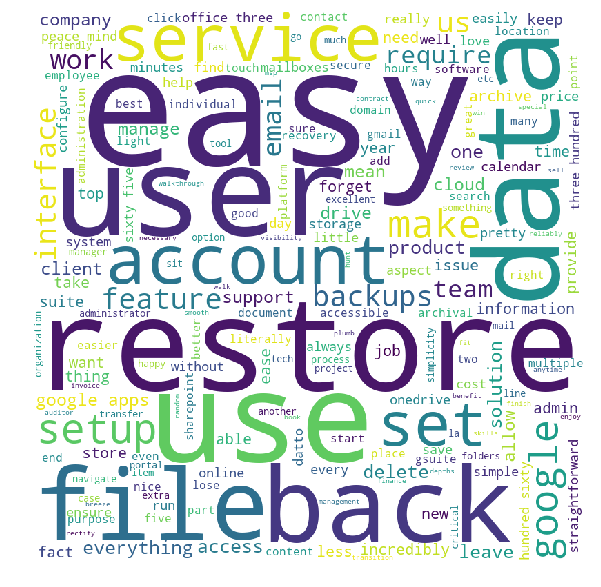

In [104]:
ls_wc = ' '
for i in ls_like:
    ls_wc = ls_wc + i + ' '
    
stopwords = set(STOPWORDS) 
stopwords.add('backup')
stopwords.add('backupify')

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(ls_wc) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#### Looking at the Top 20 words used in "What do you like best?"

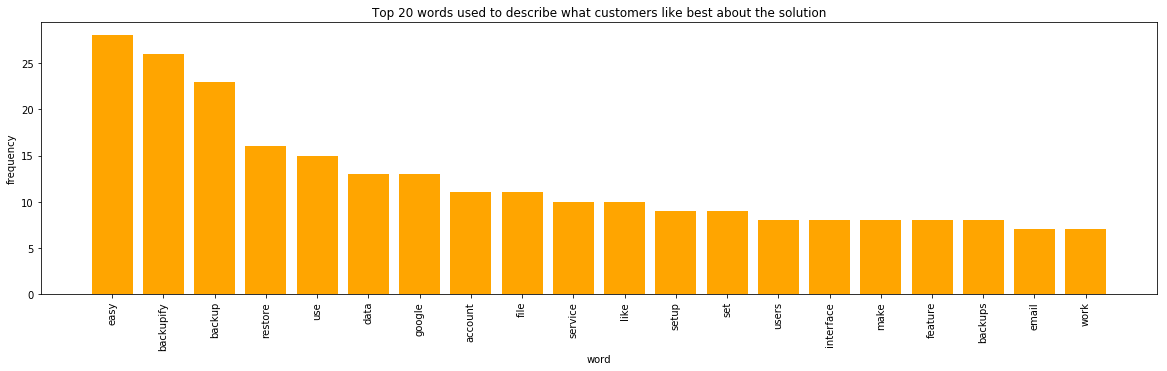

In [89]:
def top_n_words(corpus, n=None):
    w_vector = CountVectorizer(stop_words = 'english').fit(corpus)
    bow = w_vector.transform(corpus)
    sum_of_words = bow.sum(axis=0) 
    wfreq = [(w, sum_of_words[0, i]) for w, i in w_vector.vocabulary_.items()]
    wfreq =sorted(wfreq, key = lambda x: x[1], reverse=True)
    return wfreq[:n]

top_20_words = top_n_words(ls_like, 20)

df2 = pd.DataFrame(top_20_words, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 words used to describe what customers like best about the solution")
plt.show()

#### Word Cloud for "What do you dislike?"

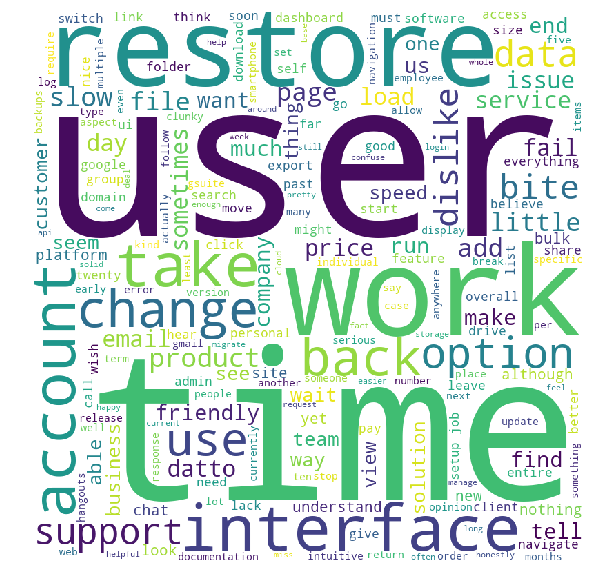

In [105]:
ls_wc = ' '
for i in ls_dislike:
    ls_wc = ls_wc + i + ' '
    
stopwords = set(STOPWORDS) 
stopwords.add('backup')
stopwords.add('backupify')

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(ls_wc) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#### Looking at the Top 20 words used in "What do you dislike?"

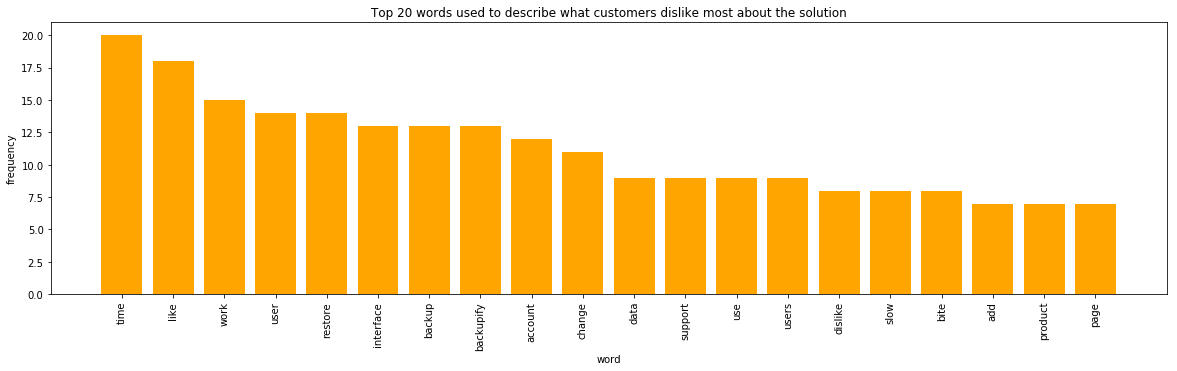

In [90]:
top_20_words_dislike = top_n_words(ls_dislike, 20)

df2 = pd.DataFrame(top_20_words_dislike, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 words used to describe what customers dislike most about the solution")
plt.show()

#### Looking at the Top 20 bigram used in "What do you like best?"

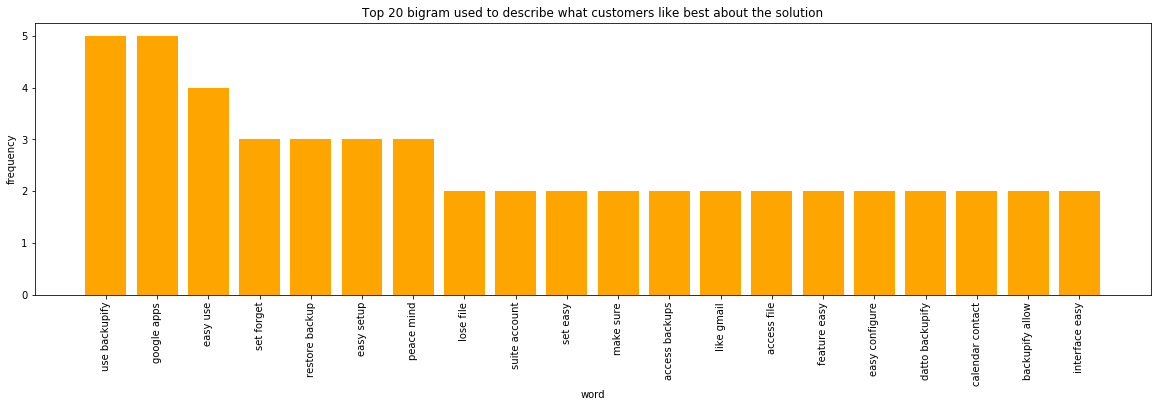

In [91]:
def top_n_bigram(corpus, n=None):
    w_vector = CountVectorizer(ngram_range=(2, 2), stop_words = 'english').fit(corpus)
    bow = w_vector.transform(corpus)
    sum_of_words = bow.sum(axis=0) 
    wfreq = [(w, sum_of_words[0, i]) for w, i in w_vector.vocabulary_.items()]
    wfreq =sorted(wfreq, key = lambda x: x[1], reverse=True)
    return wfreq[:n]


top_20_bigram = top_n_bigram(ls_like, 20)

df2 = pd.DataFrame(top_20_bigram, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 bigram used to describe what customers like best about the solution")
plt.show()

#### Looking at the Top 20 bigram used in "What do you dislike?"

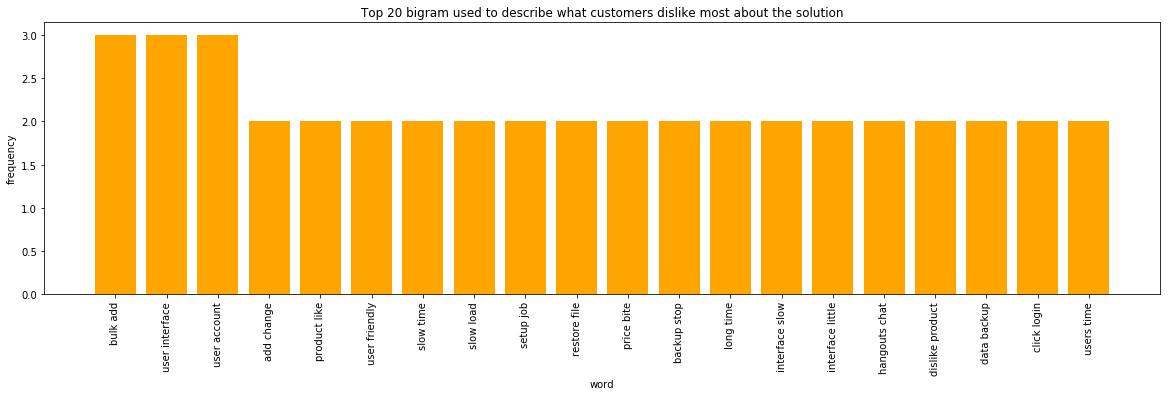

In [92]:
top_20_bigram_dislike = top_n_bigram(ls_dislike, 20)

df2 = pd.DataFrame(top_20_bigram_dislike, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 bigram used to describe what customers dislike most about the solution")
plt.show()

#### Looking at the Top 20 trigram used in "What do you like best?"

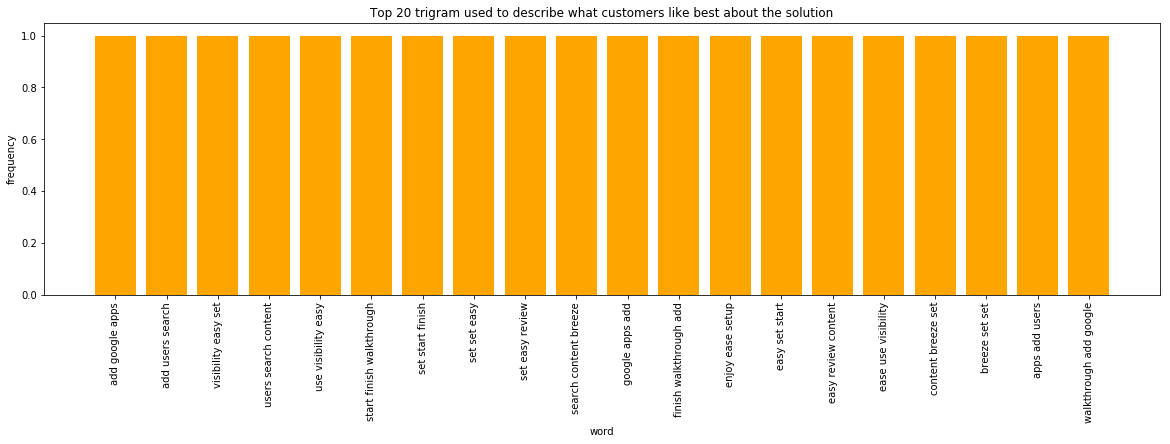

In [93]:
def top_n_trigram(corpus, n=None):
    w_vector = CountVectorizer(ngram_range=(3, 3), stop_words = 'english').fit(corpus)
    bow = w_vector.transform(corpus)
    sum_of_words = bow.sum(axis=0) 
    wfreq = [(w, sum_of_words[0, i]) for w, i in w_vector.vocabulary_.items()]
    wfreq =sorted(wfreq, key = lambda x: x[1], reverse=True)
    return wfreq[:n]


top_20_trigram = top_n_trigram(ls_like, 20)

df2 = pd.DataFrame(top_20_trigram, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 trigram used to describe what customers like best about the solution")
plt.show()

#### Looking at the Top 20 trigram used in "What do you dislike?"

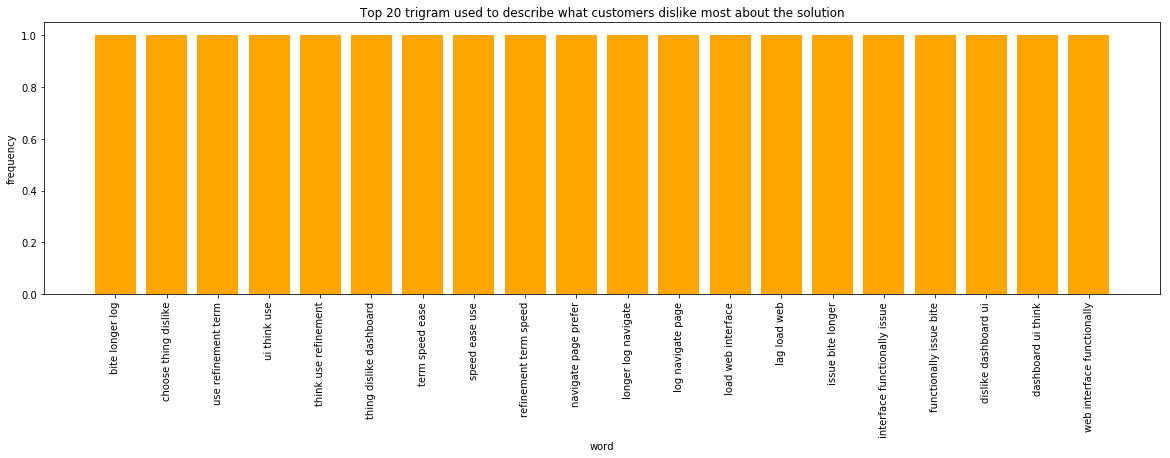

In [95]:
top_20_trigram_dislike= top_n_trigram(ls_dislike, 20)

df2 = pd.DataFrame(top_20_trigram_dislike, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 trigram used to describe what customers dislike most about the solution")
plt.show()

#### Topic Modeling for "What do you like best?" - 10 Topics

In [125]:
# We will use LDA (Latent Dirichlet Allocation) to build the topics 

split_like = pd.Series(ls_like).apply(lambda x: x.split())

dictionary = corpora.Dictionary(split_like)

doc_term_matrix = [dictionary.doc2bow(rev) for rev in split_like]

LDA = gensim.models.ldamodel.LdaModel

# Let's generate 10 topics from the corpus
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)

lda_model.print_topics()


[(0,
  '0.034*"backup" + 0.023*"restore" + 0.023*"use" + 0.017*"service" + 0.017*"back" + 0.017*"easy" + 0.017*"require" + 0.017*"data" + 0.012*"everything" + 0.012*"product"'),
 (1,
  '0.023*"data" + 0.016*"account" + 0.016*"team" + 0.016*"hundred" + 0.016*"archive" + 0.016*"sixty-five" + 0.016*"office" + 0.016*"three" + 0.016*"work" + 0.016*"backupify"'),
 (2,
  '0.018*"easy" + 0.018*"la" + 0.018*"backup" + 0.009*"make" + 0.009*"set" + 0.009*"file" + 0.009*"even" + 0.009*"able" + 0.009*"mean" + 0.009*"like"'),
 (3,
  '0.035*"easy" + 0.028*"backupify" + 0.021*"use" + 0.016*"restore" + 0.016*"also" + 0.014*"file" + 0.014*"incredibly" + 0.014*"product" + 0.014*"setup" + 0.014*"users"'),
 (4,
  '0.042*"easy" + 0.028*"backup" + 0.028*"backupify" + 0.019*"google" + 0.019*"set" + 0.014*"ease" + 0.014*"data" + 0.010*"use" + 0.010*"apps" + 0.010*"top"'),
 (5,
  '0.018*"delete" + 0.018*"mind" + 0.018*"peace" + 0.018*"portal" + 0.018*"find" + 0.018*"folders" + 0.018*"something" + 0.018*"go" + 0

In [126]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.125099 -0.103816       1        1  16.497866
4      0.002307  0.113212       2        1  15.998747
8      0.156106 -0.020775       3        1  13.000226
0      0.022189 -0.047985       4        1  12.508601
9      0.026281 -0.060570       5        1   9.519194
3     -0.013869  0.026822       6        1   9.410036
1     -0.025960  0.099841       7        1   8.332768
2      0.031882 -0.037295       8        1   6.913495
6     -0.092106  0.034014       9        1   6.118608
5      0.018268 -0.003447      10        1   1.700462, topic_info=    Category       Freq           Term      Total  loglift  logprob
5    Default  20.000000           easy  20.000000  30.0000  30.0000
33   Default   9.000000           back   9.000000  29.0000  29.0000
47   Default   7.000000           like   7.000000  28.0000  28.0000
16   Default  17.000000         backup  17.000000  27.0000  27.0000
40   Default   5.000000          email   5.000000  26.0000  26.0000
58   Default   4.000000         access   4.000000  25.0000  25.0000
148  Default   5.000000           work   5.000000  24.0000  24.0000
149  Default   6.000000      interface   6.000000  23.0000  23.0000
34   Default  19.000000      backupify  19.000000  22.0000  22.0000
94   Default   6.000000             us   6.000000  21.0000  21.0000
97   Default   4.000000         delete   4.000000  20.0000  20.0000
142  Default   2.000000           mind   2.000000  19.0000  19.0000
254  Default   2.000000           find   2.000000  18.0000  18.0000
143  Default   2.000000          peace   2.000000  17.0000  17.0000
315  Default   4.000000           also   4.000000  16.0000  16.0000
75   Default   3.000000          store   3.000000  15.0000  15.0000
35   Default   6.000000        backups   6.000000  14.0000  14.0000
12   Default  11.000000            use  11.000000  13.0000  13.0000
39   Default   4.000000          drive   4.000000  12.0000  12.0000
96   Default   8.000000        account   8.000000  11.0000  11.0000
458  Default   1.000000         portal   1.000000  10.0000  10.0000
65   Default   2.000000         ensure   2.000000   9.0000   9.0000
41   Default   8.000000           file   8.000000   8.0000   8.0000
390  Default   1.000000        folders   1.000000   7.0000   7.0000
400  Default   1.000000             go   1.000000   6.0000   6.0000
359  Default   1.000000      something   1.000000   5.0000   5.0000
108  Default   9.000000           data   9.000000   4.0000   4.0000
24   Default   4.000000        require   4.000000   3.0000   3.0000
7    Default  10.000000         google  10.000000   2.0000   2.0000
66   Default   3.000000          issue   3.000000   1.0000   1.0000
..       ...        ...            ...        ...      ...      ...
211  Topic10   0.028251      platforms   1.225156   0.3046  -6.4393
210  Topic10   0.028251  organizations   1.225156   0.3046  -6.4393
209  Topic10   0.028251         nearly   1.225156   0.3046  -6.4393
71   Topic10   0.028251      necessary   1.225156   0.3046  -6.4393
205  Topic10   0.028251            gap   1.225156   0.3046  -6.4393
204  Topic10   0.028251     experience   1.225156   0.3046  -6.4393
203  Topic10   0.028251     deployment   1.225156   0.3046  -6.4393
70   Topic10   0.028251     management   1.225156   0.3046  -6.4393
207  Topic10   0.028251          major   1.225156   0.3046  -6.4393
72   Topic10   0.028251        rectify   1.225156   0.3046  -6.4393
202  Topic10   0.028251     consistent   1.225156   0.3046  -6.4393
5    Topic10   0.310747           easy  20.203630  -0.1004  -4.0415
201  Topic10   0.028251     backupiify   1.225156   0.3046  -6.4393
200  Topic10   0.028251        address   1.225156   0.3046  -6.4393
161  Topic10   0.028251       exchange   1.368147   0.1942  -6.4393
485  Topic10   0.028251     relatively   1.320393   0.2297  -6.4393
160  Topic10   0.028251     economical   1.36

#### Topic Modeling for "What do you dislike?" - 10 Topics

In [127]:
# We will use LDA (Latent Dirichlet Allocation) to build the topics 

split_dislike = pd.Series(ls_dislike).apply(lambda x: x.split())

dictionary = corpora.Dictionary(split_dislike)

doc_term_matrix = [dictionary.doc2bow(rev) for rev in split_dislike]

LDA = gensim.models.ldamodel.LdaModel

# Let's generate 10 topics from the corpus
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)

lda_model.print_topics()

[(0,
  '0.002*"restore" + 0.002*"would" + 0.002*"although" + 0.002*"file" + 0.002*"backups" + 0.002*"link" + 0.002*"change" + 0.002*"time" + 0.002*"place" + 0.002*"lack"'),
 (1,
  '0.027*"restore" + 0.027*"time" + 0.016*"change" + 0.016*"user" + 0.012*"bite" + 0.012*"file" + 0.012*"backupify" + 0.012*"also" + 0.012*"interface" + 0.008*"price"'),
 (2,
  '0.044*"like" + 0.035*"would" + 0.018*"also" + 0.018*"restore" + 0.018*"view" + 0.018*"list" + 0.009*"little" + 0.009*"options" + 0.009*"price" + 0.009*"friendly"'),
 (3,
  '0.026*"backup" + 0.026*"chat" + 0.019*"data" + 0.019*"time" + 0.013*"datto" + 0.013*"back" + 0.013*"team" + 0.013*"take" + 0.013*"hangouts" + 0.013*"like"'),
 (4,
  '0.021*"take" + 0.021*"interface" + 0.017*"back" + 0.017*"load" + 0.014*"like" + 0.014*"work" + 0.014*"user" + 0.014*"email" + 0.011*"slow" + 0.011*"account"'),
 (5,
  '0.015*"work" + 0.015*"issue" + 0.015*"change" + 0.015*"support" + 0.015*"tell" + 0.015*"us" + 0.015*"service" + 0.010*"backupify" + 0.010

In [128]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.033783 -0.144293       1        1  19.107676
1     -0.071957 -0.071433       2        1  16.595522
5     -0.131530  0.083027       3        1  12.161799
6      0.045268 -0.012294       4        1  10.773941
8     -0.032384  0.126538       5        1  10.326761
9      0.137636  0.053726       6        1   8.899445
7      0.062790 -0.010208       7        1   8.629300
3     -0.042237 -0.008533       8        1   8.226540
2      0.056031 -0.030216       9        1   4.832403
0      0.010167  0.013686      10        1   0.446611, topic_info=    Category       Freq           Term      Total  loglift  logprob
35   Default  12.000000           like  12.000000  30.0000  30.0000
14   Default  13.000000          would  13.000000  29.0000  29.0000
147  Default   9.000000         backup   9.000000  28.0000  28.0000
99   Default  10.000000        restore  10.000000  27.0000  27.0000
274  Default   3.000000           chat   3.000000  26.0000  26.0000
51   Default   5.000000           also   5.000000  25.0000  25.0000
9    Default   5.000000           page   5.000000  24.0000  24.0000
77   Default   8.000000         change   8.000000  23.0000  23.0000
2    Default  10.000000      interface  10.000000  22.0000  22.0000
5    Default   5.000000           load   5.000000  21.0000  21.0000
68   Default   3.000000           view   3.000000  20.0000  20.0000
180  Default   6.000000           data   6.000000  19.0000  19.0000
211  Default   4.000000        service   4.000000  18.0000  18.0000
450  Default   2.000000          share   2.000000  17.0000  17.0000
38   Default   5.000000        product   5.000000  16.0000  16.0000
83   Default   4.000000           fail   4.000000  15.0000  15.0000
57   Default   2.000000           list   2.000000  14.0000  14.0000
45   Default  10.000000           user  10.000000  13.0000  13.0000
221  Default   6.000000        support   6.000000  12.0000  12.0000
67   Default   6.000000          users   6.000000  11.0000  11.0000
3    Default   4.000000          issue   4.000000  10.0000  10.0000
18   Default   5.000000        dislike   5.000000   9.0000   9.0000
47   Default   3.000000           able   3.000000   8.0000   8.0000
385  Default   4.000000             us   4.000000   7.0000   7.0000
43   Default  15.000000           time  15.000000   6.0000   6.0000
524  Default   2.000000         entire   2.000000   5.0000   5.0000
12   Default   9.000000           take   9.000000   4.0000   4.0000
172  Default   8.000000           back   8.000000   3.0000   3.0000
29   Default   2.000000             ui   2.000000   2.0000   2.0000
8    Default   2.000000       navigate   2.000000   1.0000   1.0000
..       ...        ...            ...        ...      ...      ...
99   Topic10   0.009221        restore  10.658285  -1.6414  -6.3784
14   Topic10   0.009220          would  13.099576  -1.8477  -6.3784
170  Topic10   0.009220       although   3.592544  -0.5540  -6.3784
247  Topic10   0.009220           file   5.843840  -1.0405  -6.3784
231  Topic10   0.009220        backups   2.156037  -0.0434  -6.3784
254  Topic10   0.009220           link   2.827835  -0.3146  -6.3784
77   Topic10   0.009220         change   8.557240  -1.4219  -6.3784
43   Topic10   0.009220           time  15.034190  -1.9854  -6.3784
96   Topic10   0.009220          place   2.156038  -0.0434  -6.3784
125  Topic10   0.009220           lack   2.716073  -0.2743  -6.3784
84   Topic10   0.009220          items   2.156038  -0.0434  -6.3784
241  Topic10   0.009220  documentation   2.156037  -0.0434  -6.3784
2    Topic10   0.009220      interface  10.397044  -1.6166  -6.3784
255  Topic10   0.009220        mailbox   1.385481   0.3989  -6.3784
90   Topic10   0.009220       multiple   2.156038  -0.0434  -6.3784
45   Topic10   0.009220           user  10.791039  -1.6538  -6.3784
51   Topic10   0.009220           also   5.37

#### Text Summarization "What do you like best?"

In [166]:
df_1 = df_backupify[~df_backupify['What do you like best?'].isnull()][['What do you like best?']]

# Convert the data into a list of reviews
ls_like_pt2 = [rev for rev in df_1['What do you like best?'].values.tolist()]

b = ""
for i in ls_like_pt2:
    b = b + i + ". "

In [167]:
print("The summary of reviews for what people like about the solution is: ", '\n')
print(gensim.summarization.summarizer.summarize(b, ratio=0.05, word_count=None, split=False))

The summary of reviews for what people like about the solution is:  

. I love that Backupify reliably backs up email and cloud storage files like Google Drive and OneDrive.
We use Backupify to store and keep all of our Google Suite files in a  secure backup location.
All in one solution for G-Suite admins looking for a complete save guard to core google services like Gmail, Calendar, Contacts and Drive with the possibility of providing to end users self-service restore of their own google accounts data..
With other Backup solutions, it fell to the administrator to find files a user needs to restore.
Backupify provides full backup for every element of a Google Apps account: Mail, Drive, Calendar, Contacts, and Sites.
We're very happy with the incredibly easy setup process, and the fact that we can also backup all of our sandboxes without having to pay for additional licensing on top of our production costs.
It is incredibly easy to install Backupify with new G Suite accounts when we do

In [168]:
print("The keywords from summary of reviews for what people like about the solution is: ", '\n')
print(gensim.summarization.keywords(b, ratio=0.05, split=False))

The keywords from summary of reviews for what people like about the solution is:  

backup
backups
backupify
users
user
google
data
files
file
email
emails
easy
restore
restores
restored
restorations
setup
feature
features
account
accounts
team
teams


#### Text Summarization "What do you dislike?"

In [169]:
df_1 = df_backupify[~df_backupify['What do you dislike?'].isnull()][['What do you dislike?']]

# Convert the data into a list of reviews
ls_dislike_pt2 = [rev for rev in df_1['What do you dislike?'].values.tolist()]

b = ""
for i in ls_dislike_pt2:
    b = b + i + ". "

In [170]:
print("The summary of reviews for what people dislike about the solution is: ", '\n')
print(gensim.summarization.summarizer.summarize(b, ratio=0.05, word_count=None, split=False))

The summary of reviews for what people dislike about the solution is:  

. The user interface can be a bit clunky at times, but Backupify regularly updates their product.
The user interface is kind of slow sometimes or it present errors, also when we change the employee username (when someone leaves the company) we have to wait a lot of time for this change to be reflected in backupify, it should be an option to synchronize user account whenever we need to.
. In my opinion speed and response time to searches and overall page navigation could be improved in order to make searching and exporting even faster to end users or admins.
. This is more of a statement for GSuite rather than Datto Backupify, but it's not always possible to backup/access new(er) applications - like Hangouts Chat.
not happy and when I chased this up with support, I pushed on for a little over a week of them not returning my calls, not following up on my emails (other than the automated responses) and at the end of 

In [171]:
print("The keywords from summary of reviews for what people dislike about the solution is: ", '\n')
print(gensim.summarization.keywords(b, ratio=0.05, split=False))

The keywords from summary of reviews for what people dislike about the solution is:  

like
account
accounts
backup
backups
user
users
option
optional
options
backupify
times
time
files
interface
customer
customers
pages
page
restored file
restore
restoring
restores
bit
data
little


## <span style="color:orange"> Solarwinds Backup & Recovery Analysis </span>

In [172]:
df_sw_backup.head()

,Review_Title,What do you like best?,What do you dislike?,Recommendations to others considering the product,What business problems are you solving with the product? What benefits have you realized?
0,"""Great Backup Software""",None,None,None,None
1,"""Easy to install and manage, backups just work!""",Having the ability to brand the client is nice...,I dislike that you are unable to have multiple...,None,None
2,"""SolarWinds MSP Backup is a Simple and Effecti...",The product is easy to learn and easy to deplo...,The reporting could use some work. If you have...,None,None
3,"""Logical, easy, and robust backups""",Monitoring the backups through the online port...,My only complaint would be with the notificati...,None,None
4,"""Cloud backups your workstations can afford""",A solid product that a MSP can offer to client...,The scheduling is a little clunky. It would b...,None,None


In [173]:
# Starting with What do you like best?:

# Remove rows with missing value
df_1 = df_sw_backup[~df_sw_backup['What do you like best?'].isnull()][['What do you like best?']]

# Convert the data into a list of reviews
ls_like = [rev for rev in df_1['What do you like best?'].values.tolist()]


# Remove non-ascii characters
def remove_non_ascii(sent):
        new_sent = unicodedata.normalize('NFKD', sent).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return new_sent

# convert words to lowercase
def lowercase(sent):
    new_sent = sent.lower()
    return new_sent

# Transform contracted words back into their expanded form e.g (don't) to (do not)
def expand_contractions(sent):
    return contractions.fix(sent)

# Remove punctuations
def remove_punctuations(sent):
        new_sent = re.sub(r'[^\w\s]', '', sent)
        if new_sent != '':
            return new_sent
        
# Change numers to word equivalent
def change_numbers_to_words(sent):
    a = inflect.engine()
    conv_terms = []
    x = sent.split()
    for z in x:
        if z.isdigit():
            new_term = a.number_to_words(z)
            conv_terms.append(new_term)
        else:
            conv_terms.append(z)
        x = ' '.join(conv_terms)
    return x

# Remove stop words
def rem_stopwords(sent):
    conv_terms = []
    x = sent.split()
    for z in x:
        if z not in stopwords.words('english'):
            conv_terms.append(z)
    x = ' '.join(conv_terms)
    return x

# Reduce verbs to their lemma
def lemma(sent):
    lemma = WordNetLemmatizer()
    conv_terms = []
    x = sent.split()    
    for z in x:
        lemma_f = lemma.lemmatize(z, pos='v')
        conv_terms.append(lemma_f)
    x = ' '.join(conv_terms)    
    return x

# Apply all the functions to clean data
ls_like = [remove_non_ascii(rev) for rev in ls_like]
ls_like = [lowercase(rev) for rev in ls_like]
ls_like = [expand_contractions(rev) for rev in ls_like]
ls_like = [remove_punctuations(rev) for rev in ls_like]
ls_like = [remove_punctuations(rev) for rev in ls_like]
ls_like = [change_numbers_to_words(rev) for rev in ls_like]
ls_like = [rem_stopwords(rev) for rev in ls_like]
ls_like = [lemma(rev) for rev in ls_like]

print(ls_like)

['ability brand client nice easy program installation straight forward uncomplicated run put drain system resources initial backup subsequent backups quick', 'product easy learn easy deploy product little options good reason deign keep simple reason', 'monitor backups online portal problems easy identify manage launch backup client directly via portal best feature allow instant access backup set settings need msp support chat window away techs efficient help resolve concern', 'solid product msp offer clients try backup laptops rarely stay office best part user need bother try remember anything control monitor msp backup restore baremetal mode also data backup', 'truly single pane glass feature rich without nickel dim death allow white label brand remote administration great functionality easy take quick glance support stellar provide everything need rollout successfully response time inquiries within day two general issue instantly emergency', 'like everything webdriven check backup st

In [174]:
# What do you dislike?:

# Remove rows with missing value
df_1 = df_sw_backup[~df_sw_backup['What do you dislike?'].isnull()][['What do you dislike?']]

# Convert the data into a list of reviews
ls_dislike = [rev for rev in df_1['What do you dislike?'].values.tolist()]


# Remove non-ascii characters
def remove_non_ascii(sent):
        new_sent = unicodedata.normalize('NFKD', sent).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return new_sent

# convert words to lowercase
def lowercase(sent):
    new_sent = sent.lower()
    return new_sent

# Transform contracted words back into their expanded form e.g (don't) to (do not)
def expand_contractions(sent):
    return contractions.fix(sent)

# Remove punctuations
def remove_punctuations(sent):
        new_sent = re.sub(r'[^\w\s]', '', sent)
        if new_sent != '':
            return new_sent
        
# Change numers to word equivalent
def change_numbers_to_words(sent):
    a = inflect.engine()
    conv_terms = []
    x = sent.split()
    for z in x:
        if z.isdigit():
            new_term = a.number_to_words(z)
            conv_terms.append(new_term)
        else:
            conv_terms.append(z)
        x = ' '.join(conv_terms)
    return x

# Remove stop words
def rem_stopwords(sent):
    conv_terms = []
    x = sent.split()
    for z in x:
        if z not in stopwords.words('english'):
            conv_terms.append(z)
    x = ' '.join(conv_terms)
    return x

# Reduce verbs to their lemma
def lemma(sent):
    lemma = WordNetLemmatizer()
    conv_terms = []
    x = sent.split()    
    for z in x:
        lemma_f = lemma.lemmatize(z, pos='v')
        conv_terms.append(lemma_f)
    x = ' '.join(conv_terms)    
    return x

# Apply all the functions to clean data
ls_dislike = [remove_non_ascii(rev) for rev in ls_dislike]
ls_dislike = [lowercase(rev) for rev in ls_dislike]
ls_dislike = [expand_contractions(rev) for rev in ls_dislike]
ls_dislike = [remove_punctuations(rev) for rev in ls_dislike]
ls_dislike = [remove_punctuations(rev) for rev in ls_dislike]
ls_dislike = [change_numbers_to_words(rev) for rev in ls_dislike]
ls_dislike = [rem_stopwords(rev) for rev in ls_dislike]
ls_dislike = [lemma(rev) for rev in ls_dislike]

print(ls_dislike)

['dislike unable multiple backup set would also like see ability choose data want store local speed vault vs online', 'report could use work client serious audit control place may find create report versus depend system piece service provider minimal report requirements fit bill', 'complaint would notification email configurable come regardless whether backup set complete still run', 'schedule little clunky would much nicer backup could continuous anytime connect internet similar carbonite', 'still minor bug macs laptops bite quirky would love see integrate version ncentral get speed would like bite control acceleration larger file set online help could use flesh tough find specific errors solutions knowledge base', 'would nice backup management console ability push settings profile clients next available rather wait online make change get tricky workforce mobile geographically disperse', 'start interface abysmal still bismal even move cloud base platform easy navigate intuitive either

#### Word Cloud for "What do you like best?"

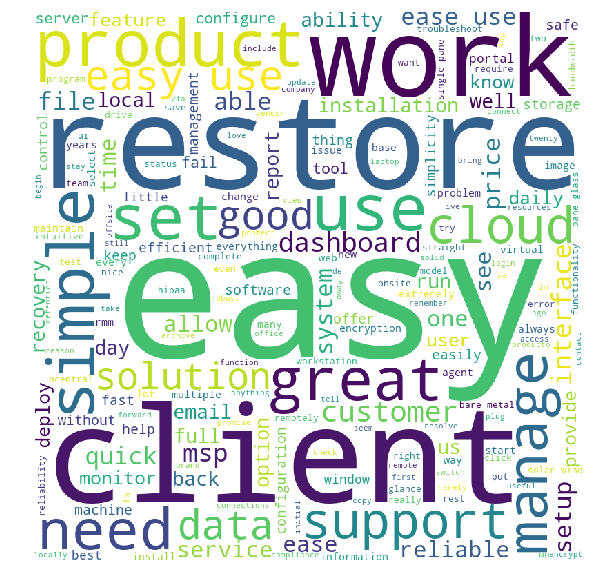

In [178]:
ls_wc = ' '
for i in ls_like:
    ls_wc = ls_wc + i + ' '
    
stopwords = set(STOPWORDS) 
stopwords.add('backup')
stopwords.add('backups')
stopwords.add('solarwinds')

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(ls_wc) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#### Looking at the Top 20 words used in "What do you like best?"

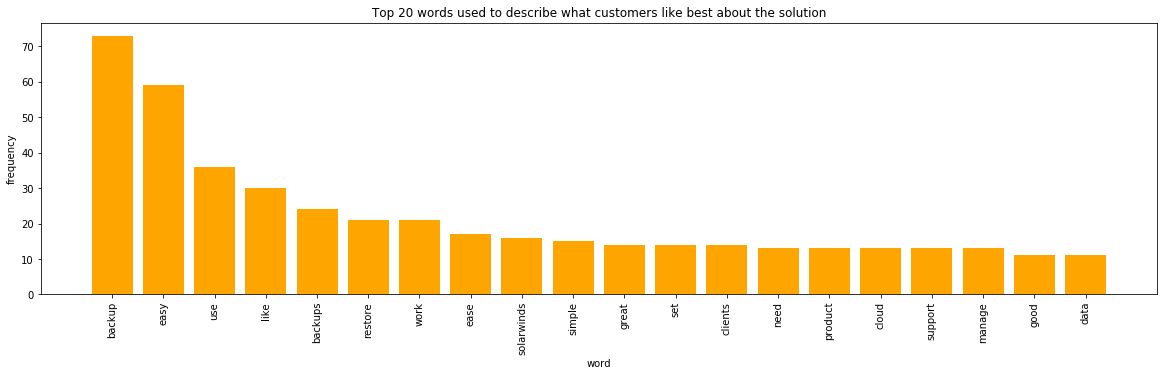

In [179]:
def top_n_words(corpus, n=None):
    w_vector = CountVectorizer(stop_words = 'english').fit(corpus)
    bow = w_vector.transform(corpus)
    sum_of_words = bow.sum(axis=0) 
    wfreq = [(w, sum_of_words[0, i]) for w, i in w_vector.vocabulary_.items()]
    wfreq =sorted(wfreq, key = lambda x: x[1], reverse=True)
    return wfreq[:n]

top_20_words = top_n_words(ls_like, 20)

df2 = pd.DataFrame(top_20_words, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 words used to describe what customers like best about the solution")
plt.show()

#### Word Cloud for "What do you dislike?"

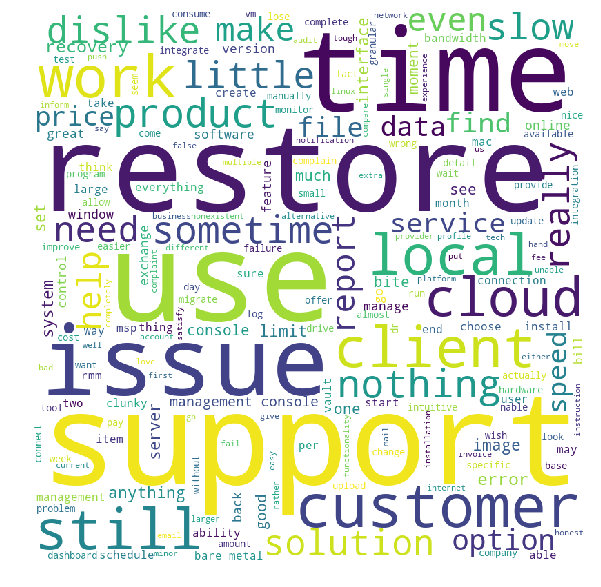

In [180]:
ls_wc = ' '
for i in ls_dislike:
    ls_wc = ls_wc + i + ' '
    
stopwords = set(STOPWORDS) 
stopwords.add('backup')
stopwords.add('backups')
stopwords.add('solarwinds')

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(ls_wc) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#### Looking at the Top 20 words used in "What do you dislike?"

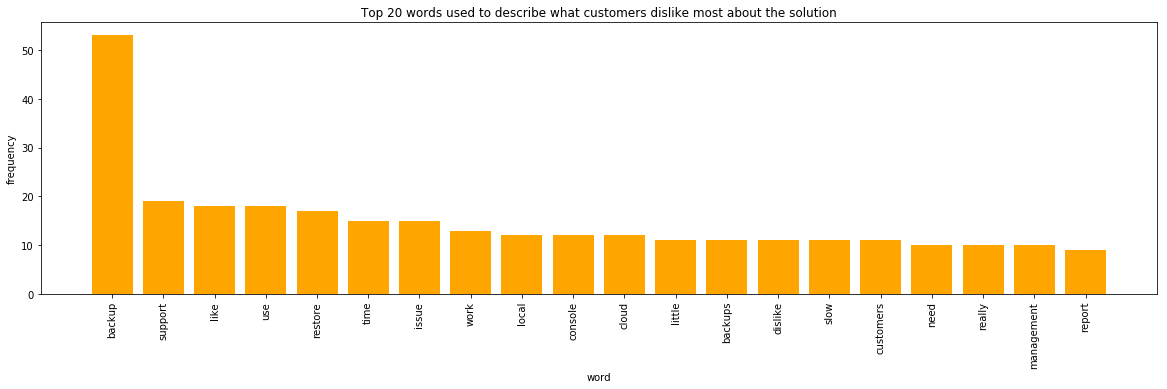

In [181]:
top_20_words_dislike = top_n_words(ls_dislike, 20)

df2 = pd.DataFrame(top_20_words_dislike, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 words used to describe what customers dislike most about the solution")
plt.show()

#### Looking at the Top 20 bigram used in "What do you like best?"

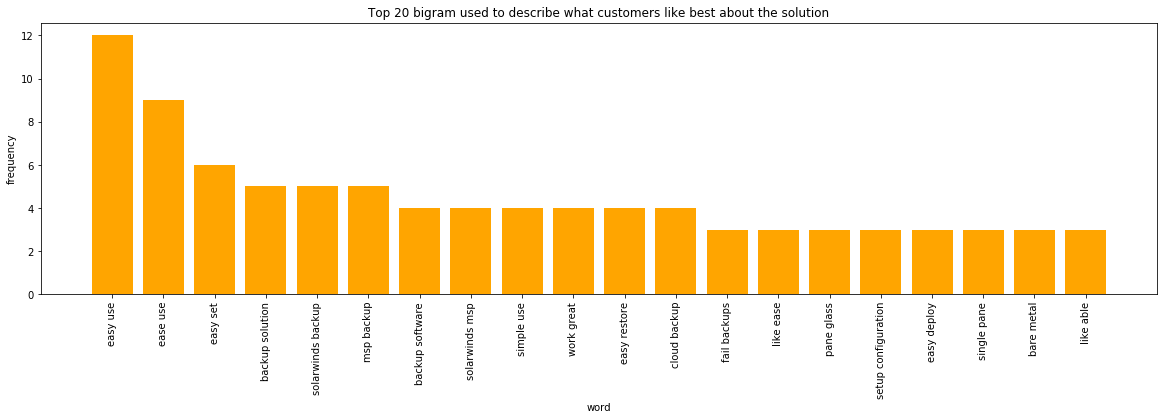

In [182]:
def top_n_bigram(corpus, n=None):
    w_vector = CountVectorizer(ngram_range=(2, 2), stop_words = 'english').fit(corpus)
    bow = w_vector.transform(corpus)
    sum_of_words = bow.sum(axis=0) 
    wfreq = [(w, sum_of_words[0, i]) for w, i in w_vector.vocabulary_.items()]
    wfreq =sorted(wfreq, key = lambda x: x[1], reverse=True)
    return wfreq[:n]


top_20_bigram = top_n_bigram(ls_like, 20)

df2 = pd.DataFrame(top_20_bigram, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 bigram used to describe what customers like best about the solution")
plt.show()

#### Looking at the Top 20 bigram used in "What do you dislike?"

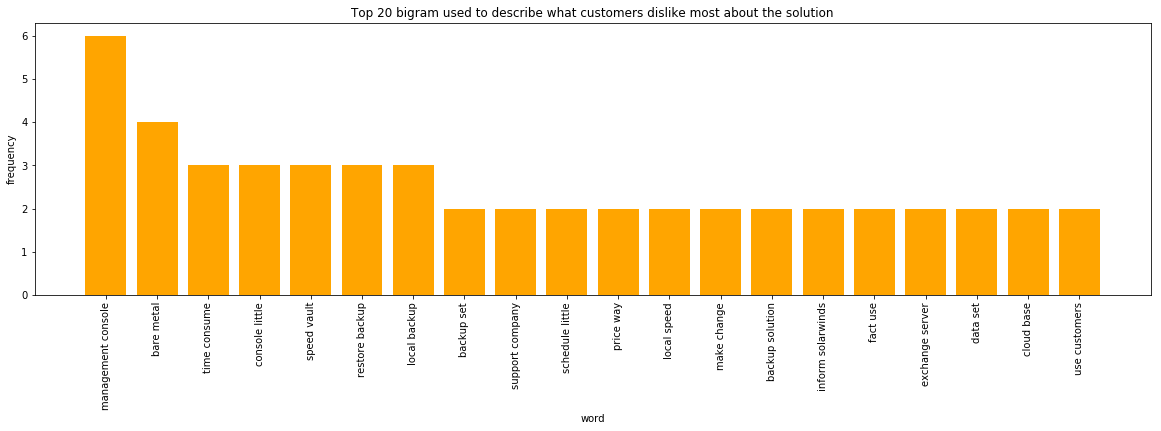

In [183]:
top_20_bigram_dislike = top_n_bigram(ls_dislike, 20)

df2 = pd.DataFrame(top_20_bigram_dislike, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 bigram used to describe what customers dislike most about the solution")
plt.show()

#### Looking at the Top 20 trigram used in "What do you like best?"

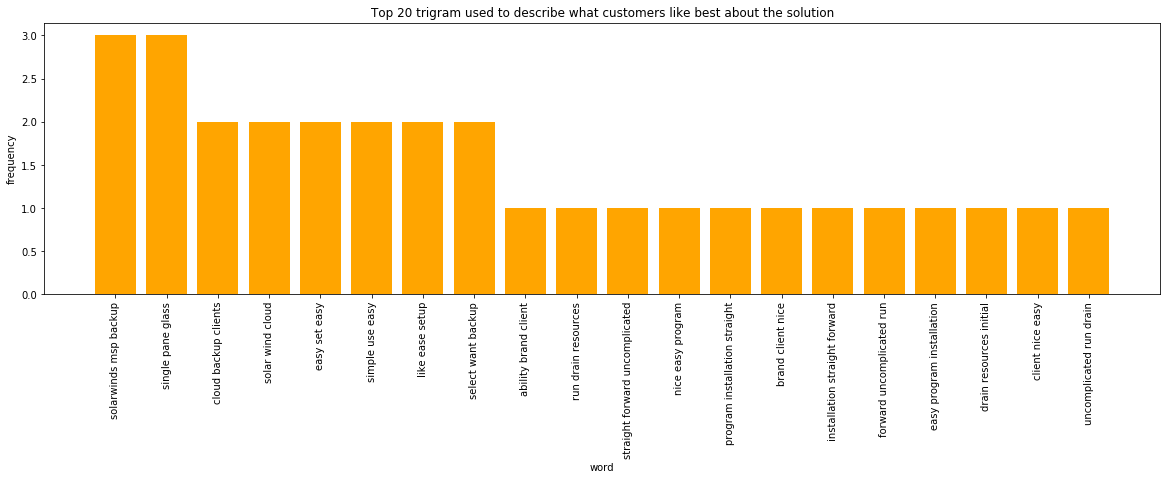

In [184]:
def top_n_trigram(corpus, n=None):
    w_vector = CountVectorizer(ngram_range=(3, 3), stop_words = 'english').fit(corpus)
    bow = w_vector.transform(corpus)
    sum_of_words = bow.sum(axis=0) 
    wfreq = [(w, sum_of_words[0, i]) for w, i in w_vector.vocabulary_.items()]
    wfreq =sorted(wfreq, key = lambda x: x[1], reverse=True)
    return wfreq[:n]


top_20_trigram = top_n_trigram(ls_like, 20)

df2 = pd.DataFrame(top_20_trigram, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 trigram used to describe what customers like best about the solution")
plt.show()

#### Looking at the Top 20 trigram used in "What do you dislike?"

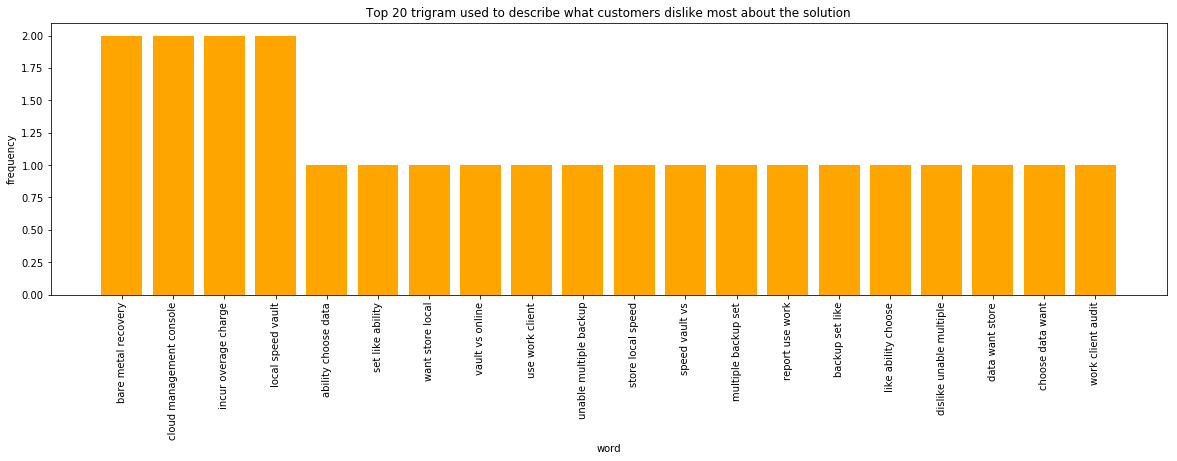

In [185]:
top_20_trigram_dislike= top_n_trigram(ls_dislike, 20)

df2 = pd.DataFrame(top_20_trigram_dislike, columns = ['word' , 'freq'])

a = df2.groupby('word').sum()['freq'].reset_index().sort_values(by = 'freq', ascending=False)
plt.figure(figsize=(20,5))
plt.bar(a['word'], a['freq'], color = ("orange"))
plt.xlabel('word')
plt.ylabel('frequency')
plt.xticks(a['word'], a['word'], rotation='vertical')
plt.title("Top 20 trigram used to describe what customers dislike most about the solution")
plt.show()

#### Topic Modeling for "What do you like best?" - 10 Topics

In [186]:
# We will use LDA (Latent Dirichlet Allocation) to build the topics 

split_like = pd.Series(ls_like).apply(lambda x: x.split())

dictionary = corpora.Dictionary(split_like)

doc_term_matrix = [dictionary.doc2bow(rev) for rev in split_like]

LDA = gensim.models.ldamodel.LdaModel

# Let's generate 10 topics from the corpus
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)

lda_model.print_topics()

[(0,
  '0.020*"like" + 0.019*"backups" + 0.019*"email" + 0.016*"backup" + 0.015*"manage" + 0.015*"also" + 0.015*"lot" + 0.014*"see" + 0.010*"report" + 0.010*"day"'),
 (1,
  '0.030*"backup" + 0.016*"without" + 0.014*"time" + 0.014*"need" + 0.013*"like" + 0.012*"easy" + 0.012*"work" + 0.012*"daily" + 0.012*"clients" + 0.012*"solarwinds"'),
 (2,
  '0.039*"backup" + 0.024*"clients" + 0.020*"use" + 0.020*"cloud" + 0.020*"easy" + 0.015*"like" + 0.015*"great" + 0.015*"restore" + 0.010*"setup" + 0.010*"tool"'),
 (3,
  '0.066*"easy" + 0.030*"restore" + 0.028*"use" + 0.023*"backup" + 0.022*"deploy" + 0.022*"manage" + 0.018*"configure" + 0.018*"interface" + 0.013*"data" + 0.013*"start"'),
 (4,
  '0.023*"like" + 0.023*"backup" + 0.016*"support" + 0.016*"easy" + 0.012*"ability" + 0.012*"able" + 0.012*"great" + 0.012*"interface" + 0.008*"client" + 0.008*"information"'),
 (5,
  '0.063*"easy" + 0.034*"use" + 0.031*"work" + 0.021*"great" + 0.021*"monitor" + 0.016*"system" + 0.016*"backup" + 0.015*"supp

In [187]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.051855  0.018279       1        1  16.338970
1      0.016096  0.135807       2        1  11.752563
4      0.012419 -0.035099       3        1  11.235163
6      0.010378 -0.045212       4        1  10.829438
3      0.049647 -0.045269       5        1   9.605419
0      0.026750  0.113413       6        1   8.921926
2      0.032315 -0.029866       7        1   8.439913
8      0.028534 -0.027059       8        1   7.879095
5     -0.012507 -0.096526       9        1   7.556965
9     -0.215486  0.011533      10        1   7.440546, topic_info=    Category       Freq           Term      Total  loglift  logprob
6    Default  42.000000           easy  42.000000  30.0000  30.0000
289  Default  26.000000            use  26.000000  29.0000  29.0000
71   Default  15.000000        restore  15.000000  28.0000  28.0000
43   Default   9.000000         manage   9.000000  27.0000  27.0000
122  Default  15.000000           work  15.000000  26.0000  26.0000
371  Default   8.000000      interface   8.000000  25.0000  25.0000
86   Default  10.000000          great  10.000000  24.0000  24.0000
21   Default   4.000000         deploy   4.000000  23.0000  23.0000
61   Default  10.000000        clients  10.000000  22.0000  22.0000
44   Default   4.000000        monitor   4.000000  21.0000  21.0000
168  Default   5.000000          email   5.000000  20.0000  20.0000
29   Default  11.000000         simple  11.000000  19.0000  19.0000
149  Default  10.000000          cloud  10.000000  18.0000  18.0000
51   Default  10.000000            set  10.000000  17.0000  17.0000
239  Default   4.000000      configure   4.000000  16.0000  16.0000
18   Default   6.000000         system   6.000000  15.0000  15.0000
53   Default   9.000000        support   9.000000  14.0000  14.0000
63   Default   8.000000           data   8.000000  13.0000  13.0000
102  Default   6.000000           time   6.000000  12.0000  12.0000
272  Default   2.000000             un   2.000000  11.0000  11.0000
432  Default   2.000000             la   2.000000  10.0000  10.0000
426  Default   2.000000              e   2.000000   9.0000   9.0000
107  Default   4.000000        without   4.000000   8.0000   8.0000
126  Default   4.000000           fast   4.000000   7.0000   7.0000
365  Default   8.000000      dashboard   8.000000   6.0000   6.0000
331  Default   4.000000      customers   4.000000   5.0000   5.0000
171  Default   5.000000         report   5.000000   4.0000   4.0000
57   Default   8.000000           also   8.000000   3.0000   3.0000
27   Default  10.000000        product  10.000000   2.0000   2.0000
9    Default   5.000000   installation   5.000000   1.0000   1.0000
..       ...        ...            ...        ...      ...      ...
431  Topic10   0.752639        inviati   1.397222   1.9796  -5.1267
420  Topic10   0.752639      compressi   1.397222   1.9796  -5.1267
430  Topic10   0.752638             il   1.397222   1.9796  -5.1267
434  Topic10   0.752638            nel   1.397222   1.9796  -5.1267
428  Topic10   0.752638     efficiente   1.397222   1.9796  -5.1267
423  Topic10   0.752638             da   1.397222   1.9796  -5.1267
40   Topic10   0.752638       identify   1.397222   1.9796  -5.1267
53   Topic10   1.436908        support   9.980051   0.6601  -4.4800
1    Topic10   2.121141         backup  53.952793  -0.6379  -4.0906
419  Topic10   0.752638  centralizzata   1.397222   1.9796  -5.1267
417  Topic10   0.752639     accrescere   1.397222   1.9796  -5.1267
35   Topic10   0.752639        concern   1.397222   1.9796  -5.1267
4    Topic10   0.752651         client   6.351472   0.4654  -5.1267
51   Topic10   0.752649            set  10.676166  -0.0539  -5.1267
93   Topic10   0.752648        provide   4.981491   0.7083  -5.1267
402  Topic10   0.752647            web   3.648083   1.0199  -5.1267
46   Topic10   0.752646           need  10.05

#### Topic Modeling for "What do you dislike?" - 10 Topics

In [188]:
# We will use LDA (Latent Dirichlet Allocation) to build the topics 

split_dislike = pd.Series(ls_dislike).apply(lambda x: x.split())

dictionary = corpora.Dictionary(split_dislike)

doc_term_matrix = [dictionary.doc2bow(rev) for rev in split_dislike]

LDA = gensim.models.ldamodel.LdaModel

# Let's generate 10 topics from the corpus
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)

lda_model.print_topics()

[(0,
  '0.046*"issue" + 0.026*"backup" + 0.016*"need" + 0.016*"work" + 0.016*"vault" + 0.011*"file" + 0.011*"service" + 0.011*"user" + 0.011*"speed" + 0.011*"local"'),
 (1,
  '0.031*"cloud" + 0.027*"management" + 0.018*"console" + 0.018*"backup" + 0.014*"like" + 0.009*"recovery" + 0.009*"also" + 0.009*"data" + 0.009*"choose" + 0.009*"clunky"'),
 (2,
  '0.018*"slow" + 0.012*"take" + 0.012*"make" + 0.012*"local" + 0.012*"large" + 0.012*"items" + 0.012*"cover" + 0.012*"backupify" + 0.012*"somewhat" + 0.007*"software"'),
 (3,
  '0.038*"backup" + 0.012*"could" + 0.012*"like" + 0.012*"use" + 0.012*"may" + 0.012*"report" + 0.012*"local" + 0.012*"would" + 0.009*"restore" + 0.009*"work"'),
 (4,
  '0.019*"use" + 0.019*"would" + 0.019*"customers" + 0.019*"price" + 0.012*"management" + 0.012*"still" + 0.012*"help" + 0.012*"work" + 0.012*"time" + 0.012*"speed"'),
 (5,
  '0.045*"backup" + 0.029*"support" + 0.018*"would" + 0.016*"solarwinds" + 0.016*"solution" + 0.016*"even" + 0.013*"really" + 0.013*

In [189]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.011202  0.059471       1        1  15.550282
9      0.081420 -0.093217       2        1  14.364691
5      0.106241 -0.105973       3        1  14.111562
4      0.055495  0.070173       4        1  11.153198
6     -0.173047 -0.064343       5        1   8.765130
1      0.013303  0.106598       6        1   8.668847
7      0.023674  0.059318       7        1   7.412380
8     -0.020116 -0.034749       8        1   7.117213
0     -0.014048  0.023761       9        1   7.094965
2     -0.061720 -0.021039      10        1   5.761731, topic_info=    Category       Freq        Term      Total  loglift  logprob
278  Default  10.000000       issue  10.000000  30.0000  30.0000
87   Default   8.000000     console   8.000000  29.0000  29.0000
91   Default   7.000000  management   7.000000  28.0000  28.0000
545  Default   8.000000     nothing   8.000000  27.0000  27.0000
147  Default  14.000000     support  14.000000  26.0000  26.0000
108  Default   8.000000       cloud   8.000000  25.0000  25.0000
23   Default   8.000000       could   8.000000  24.0000  24.0000
5    Default   8.000000     dislike   8.000000  23.0000  23.0000
33   Default   6.000000      report   6.000000  22.0000  22.0000
181  Default   8.000000   customers   8.000000  21.0000  21.0000
2    Default  38.000000      backup  38.000000  20.0000  20.0000
500  Default   7.000000        slow   7.000000  19.0000  19.0000
57   Default   7.000000      little   7.000000  18.0000  18.0000
160  Default  12.000000     restore  12.000000  17.0000  17.0000
225  Default   6.000000       price   6.000000  16.0000  16.0000
172  Default   8.000000      cannot   8.000000  15.0000  15.0000
237  Default   7.000000  solarwinds   7.000000  14.0000  14.0000
7    Default   8.000000       local   8.000000  13.0000  13.0000
40   Default   9.000000        work   9.000000  12.0000  12.0000
112  Default   5.000000   interface   5.000000  11.0000  11.0000
229  Default   7.000000      really   7.000000  10.0000  10.0000
275  Default   8.000000   sometimes   8.000000   9.0000   9.0000
12   Default   6.000000       speed   6.000000   8.0000   8.0000
127  Default   5.000000    anything   5.000000   7.0000   7.0000
15   Default   3.000000       vault   3.000000   6.0000   6.0000
111  Default   7.000000        even   7.000000   5.0000   5.0000
649  Default   5.000000      moment   5.000000   4.0000   4.0000
18   Default  19.000000       would  19.000000   3.0000   3.0000
238  Default   6.000000    solution   6.000000   2.0000   2.0000
38   Default  13.000000         use  13.000000   1.0000   1.0000
..       ...        ...         ...        ...      ...      ...
745  Topic10   0.635285       solve   1.250898   2.1764  -5.0316
530  Topic10   0.635285   costpergb   1.250898   2.1764  -5.0316
531  Topic10   0.635285    datasets   1.250898   2.1764  -5.0316
289  Topic10   1.212843       items   2.560755   2.1066  -4.3850
419  Topic10   1.212854        take   3.155634   1.8977  -4.3850
397  Topic10   1.212846       large   3.177942   1.8907  -4.3850
500  Topic10   1.790439        slow   7.999392   1.3570  -3.9955
90   Topic10   1.212852        make   6.815886   1.1277  -4.3850
7    Topic10   1.212852       local   8.731182   0.8800  -4.3850
347  Topic10   0.635301    software   4.227243   0.9587  -5.0316
67   Topic10   0.635297        file   6.009565   0.6069  -5.0316
337  Topic10   0.635295     feature   3.976458   1.0199  -5.0316
158  Topic10   0.635294       image   5.318352   0.7291  -5.0316
285  Topic10   0.635294    exchange   4.243525   0.9549  -5.0316
221  Topic10   0.635294       offer   2.746592   1.3899  -5.0316
364  Topic10   0.635291       limit   5.491166   0.6971  -5.0316
418  Topic10   0.635291        sure   3.386801   1.1804  -5.0316
420  Topic10   0.635291      upload   2.584159   1.4509  -5.0316
334  Topic10   0.635290      delete   1.983199   1.7155  -5

#### Text Summarization "What do you like best?"

In [190]:
df_1 = df_sw_backup[~df_sw_backup['What do you like best?'].isnull()][['What do you like best?']]

# Convert the data into a list of reviews
ls_like_pt2 = [rev for rev in df_1['What do you like best?'].values.tolist()]

b = ""
for i in ls_like_pt2:
    b = b + i + ". "

In [191]:
print("The summary of reviews for what people like about the solution is: ", '\n')
print(gensim.summarization.summarizer.summarize(b, ratio=0.05, word_count=None, split=False))

The summary of reviews for what people like about the solution is:  

I not only like the ease of setup , but the reports and daily emails regarding the backups are extremely useful.
I like being able to install the backup, set the parameters, and then it just works.
I like being able to get a daily report for my clients showing me the status of their backup without the need to login to the portal every time..
It is software as a service (no vendor hardware lock in) and very flexible from file backup to full bare metal recovery, onsite or offsite, simple and fair pricing model..
I like that the product allows direct to cloud full image backups with intra-daily options with the ability to have a local copy as well..
I like the easy way to deploy, configure and wait the first backup is done!
. Secure cloud backup that keeps my clients safe at a good price.
Simple to use, easy set up , configuration, quick to get a support rep when needed.
Ease of use when setting up a new client's backup

In [192]:
print("The keywords from summary of reviews for what people like about the solution is: ", '\n')
print(gensim.summarization.keywords(b, ratio=0.05, split=False))

The keywords from summary of reviews for what people like about the solution is:  

backup
backups
easy
easiness
great
restored
restore
restores
restoring
manage
management
managed
manageability
managing
customers
customer
useful
use
client
clients
works
working
work
worked
pricing
price
priced
cloud
time
timely
times
files
file
support
recovery
remote
remotely
ease
product
products
production
solarwinds
solarwind


#### Text Summarization "What do you dislike?"

In [195]:
df_1 = df_sw_backup[~df_sw_backup['What do you dislike?'].isnull()][['What do you dislike?']]

# Convert the data into a list of reviews
ls_dislike_pt2 = [rev for rev in df_1['What do you dislike?'].values.tolist()]

b = ""
for i in ls_dislike_pt2:
    b = b + i + ". "

In [196]:
print("The summary of reviews for what people dislike about the solution is: ", '\n')
print(gensim.summarization.summarizer.summarize(b, ratio=0.05, word_count=None, split=False))

The summary of reviews for what people dislike about the solution is:  

It would be nice if the backup management console had the ability to push settings and profiles to clients when they are next available rather than waiting for them to be online to make changes.
Anyways, we will be using Solarwinds backup for the time being, until we migrated everything, hopefully we won't have to cope with their "support" and if (really, really) needed they will still provide support..
The per-device pricing for the MSP integrated product helps with smaller customers so if you have a bunch of small data set customers this is a good option but still doesn't work if you are trying to backup enterprise customers..
The only reservation I have is that at customer sites where bandwidth is limited, initial backup images can take several days to upload, so make sure that a local "speedvault" drive is configured..
I miss not having the backup history easily accessible like it is in the standalone version 

In [197]:
print("The keywords from summary of reviews for what people dislike about the solution is: ", '\n')
print(gensim.summarization.keywords(b, ratio=0.05, split=False))

The keywords from summary of reviews for what people dislike about the solution is:  

backup
backups
restore
restoring
restores
restoration
management
manage
managed
managers
support
supported
localized
little
recovery
recoveries
like
cloud
non
issues
issue
reporting
report
reports
customers
customer
customizations
local speed
options
option
user
bit
exchange
products
product
speeds
solutions
solution
slow
